<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

**Importante: la entrega debe contener el notebook (.ipynb) y su HTML tras la completa ejecución secuencial (.html) donde se pueda ver el código y los resultados. Para exportar el notebook a HTML puedes hacerlo desde el menú File → Download as → HTML.**

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **[Ejemplo práctico: diseño de redes de transporte](#ej2)**: clustering y análisis.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: Oriol Marco Sanchez</strong>
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
import random

import haversine as hs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.
import smopy
import tqdm

import kruskal

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (5 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [2]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

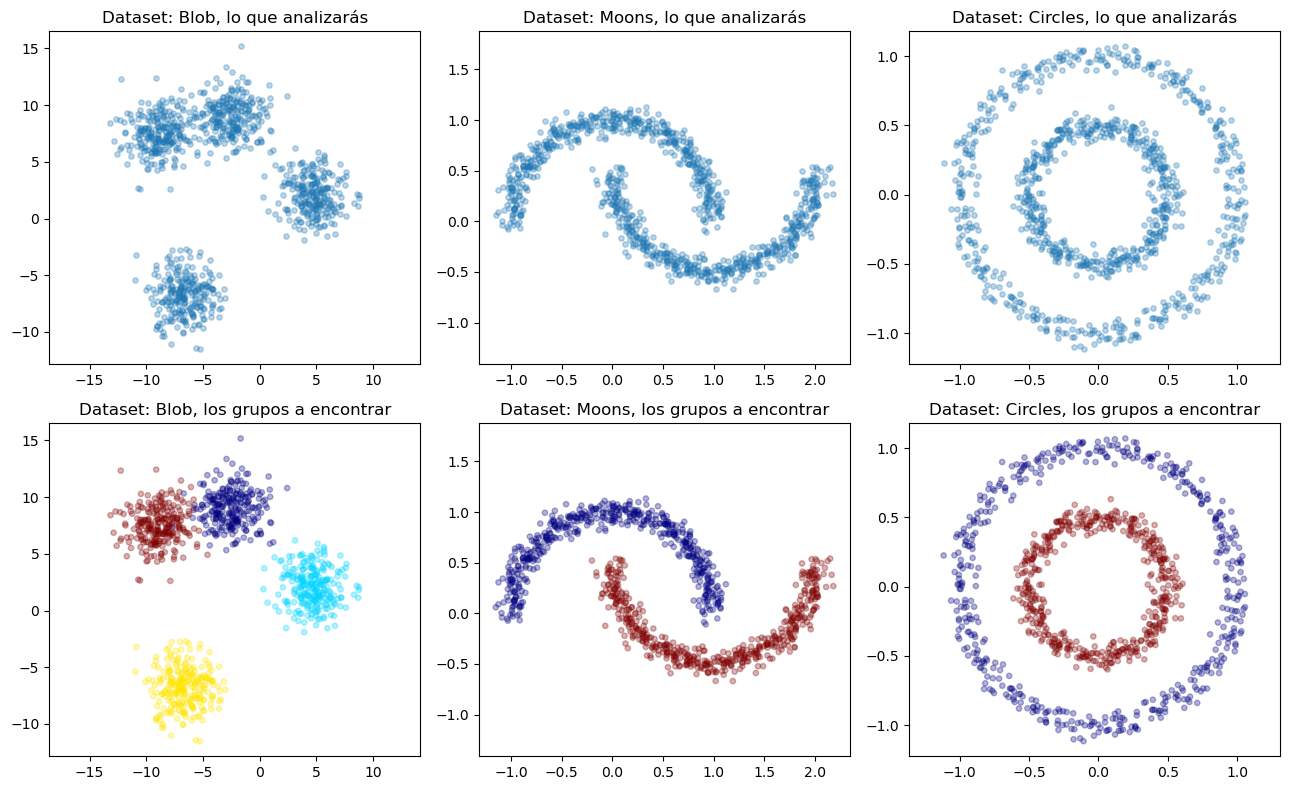

In [3]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [4]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

100%|██████████| 9/9 [00:00<00:00, 15.18it/s]


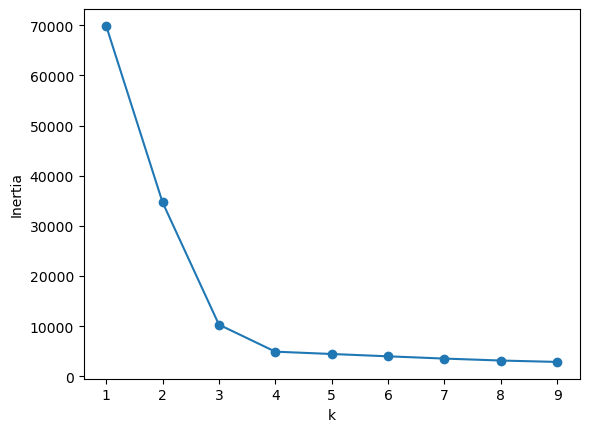

In [9]:
def plot_elbow(X, k_range=range(1, 10)):
    inertias = []
    for k in tqdm.tqdm(k_range):
        kmeans = cluster.KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    plt.plot(k_range, inertias, marker='o')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.show()
    
plot_elbow(X)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

En la gráfica anterior se puede observar como a medida que aumenta el número de clústers, el valor del erro se va reduciendo. Se puede observar que a partir de un número de clústers de 4, no se observa una mejora significativa en cuanto a la reducción del error. En este sentido, podemos afirmar que el número original de clústers es 4.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

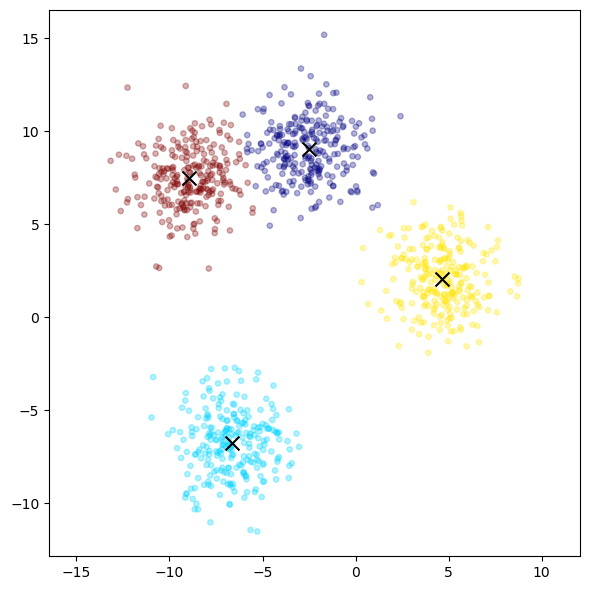

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
kmeans = cluster.KMeans(n_clusters=4, random_state=42, algorithm='full')
ax.scatter(X[:,0], X[:,1], s=15, c=kmeans.fit_predict(X), alpha=.3, cmap='jet')
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='k', marker='x')
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado. 
</div>

Usando k-means con distancia euclídea asumimos que los clusters son n-esferas. En la práctica podemos verlo como una teselación de Voronoi, que es lo que se observa en los resultados anteriores. Separando los distintos blobs de forma aceptable.

In [15]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

100%|██████████| 9/9 [00:00<00:00, 17.09it/s]


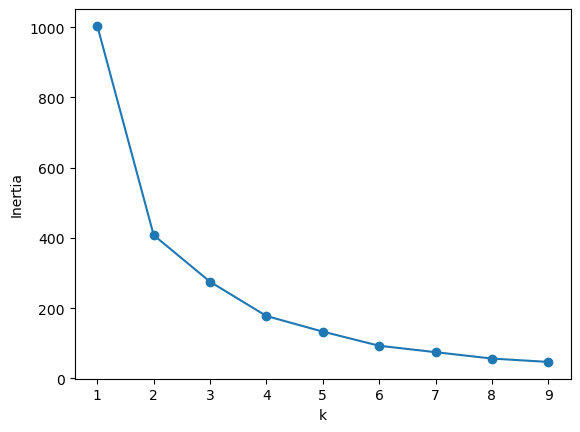

In [16]:
distances = plot_elbow(X, k_range=range(1, 10))

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

En este caso, no se puede observar una diferenciación perfecte para un número de clústers correctos, ja que el número ideal en este caso es 2.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

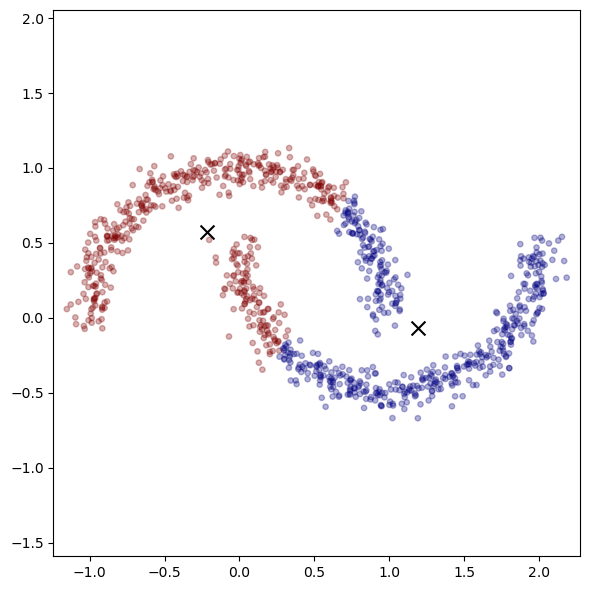

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
kmeans = cluster.KMeans(n_clusters=2, random_state=42, algorithm='full')
ax.scatter(X[:,0], X[:,1], s=15, c=kmeans.fit_predict(X), alpha=.3, cmap='jet')
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='k', marker='x')
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Usando k-means con distancia euclídea asumimos que los clusters son n-esferas. En la práctica podemos verlo como una teselación de Voronoi, que es lo que se observa en los resultados anteriores.

Es normal que no se produzcan los resultados esperados porque los clusters tienen distintas formas y no se ciñen a celdas de Voronoi.

In [18]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

100%|██████████| 9/9 [00:00<00:00, 14.75it/s]


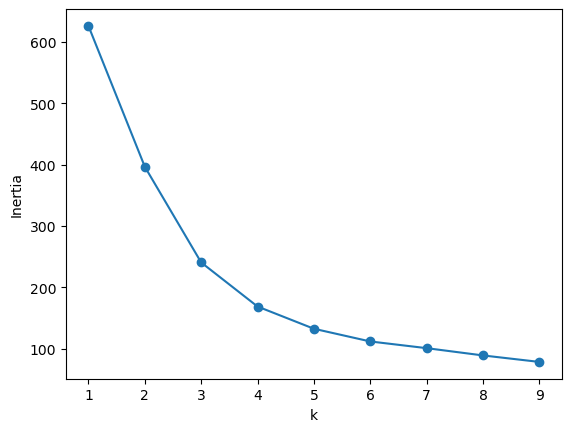

In [19]:
distances = plot_elbow(X, k_range=range(1, 10))

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

En este caso, no se puede observar una diferenciación perfecte para un número de clústers correctos, ja que el número ideal en este caso es 2.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

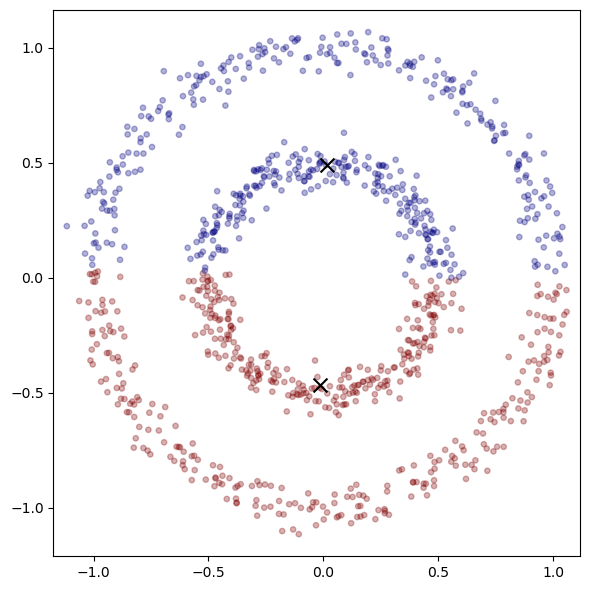

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
kmeans = cluster.KMeans(n_clusters=2, random_state=42, algorithm='full')
ax.scatter(X[:,0], X[:,1], s=15, c=kmeans.fit_predict(X), alpha=.3, cmap='jet')
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='k', marker='x')
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Usando k-means con distancia euclídea asumimos que los clusters son n-esferas. En la práctica podemos verlo como una teselación de Voronoi, que es lo que se observa en los resultados anteriores.

Es normal que no se produzcan los resultados esperados porque los clusters tienen distintas formas y no se ciñen a celdas de Voronoi.

### 1 b. Algoritmos basados en densidad: DBSCAN

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los dos grupos subyacentes.

Ésta es una visualización intuitiva de su funcionamiento: https://www.youtube.com/watch?v=RDZUdRSDOok

In [21]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

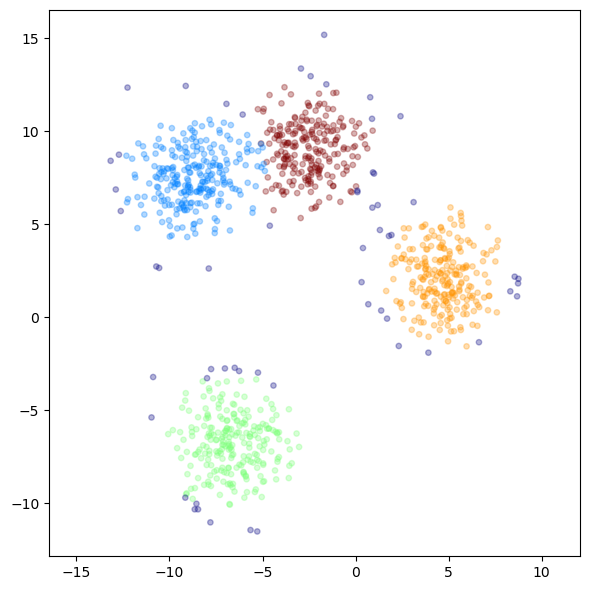

In [28]:
model_db = cluster.DBSCAN(eps=2.1, min_samples=100, n_jobs=-1)
clusters = model_db.fit_predict(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X[:,0], X[:,1], s=15, c=clusters, alpha=.3, cmap='jet')
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Usando DBSCAN con un eps de 2.1 se consigue encontrar los cuatro clusters porque tienen mucha densidad en su centro y están suficientemente separados. Eso hace que al guiarse por la densidad de puntos se puedan distinguir las estructuras.

In [29]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBSCAN jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

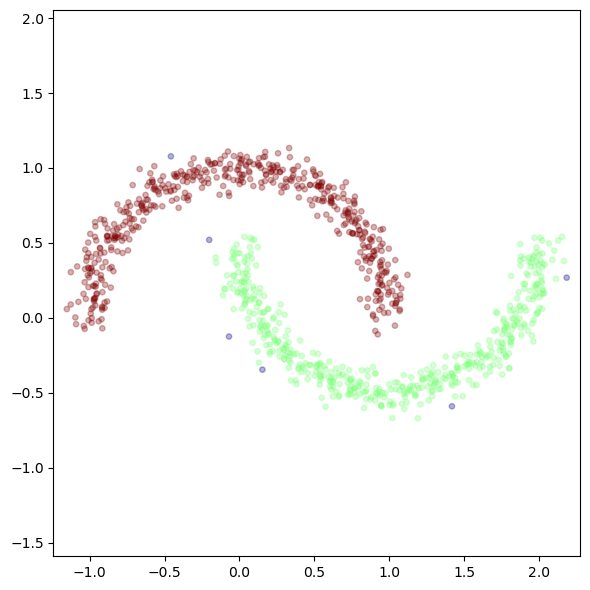

In [34]:
model_db = cluster.DBSCAN(eps=0.11, min_samples=10, n_jobs=-1)
clusters = model_db.fit_predict(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X[:,0], X[:,1], s=15, c=clusters, alpha=.3, cmap='jet')
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Usando DBSCAN con un eps de 0.11 se consigue encontrar ambos clusters porque ambas lunes tienen una densidad constante a lo largo de cada uno de ellas y están suficientemente separadas. Eso hace que al guiarse por la densidad de puntos se puedan distinguir ambas estructuras.

In [35]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

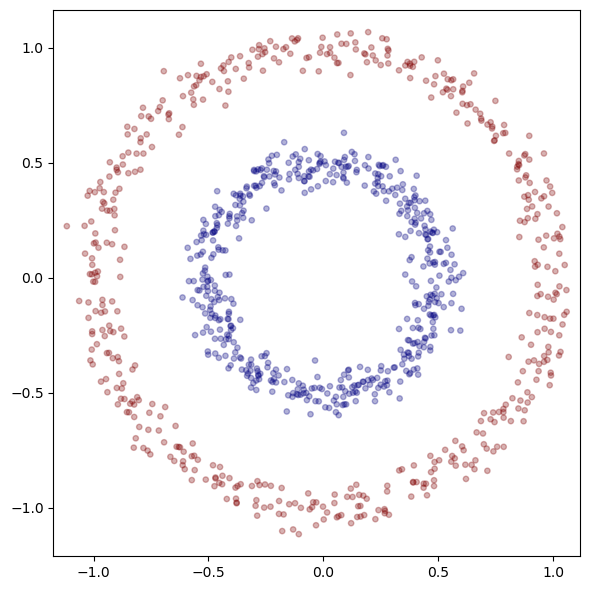

In [37]:
model_db = cluster.DBSCAN(eps=0.10, min_samples=5, n_jobs=-1)
clusters = model_db.fit_predict(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X[:,0], X[:,1], s=15, c=clusters, alpha=.3, cmap='jet')
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Usando DBSCAN con un eps de 0.10 se consigue encontrar ambos clusters porque ambos anillos tienen una densidad constante a lo largo de cada uno de ellos y están suficientemente separados. Eso hace que al guiarse por la densidad de puntos se puedan distinguir ambas estructuras.

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [38]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

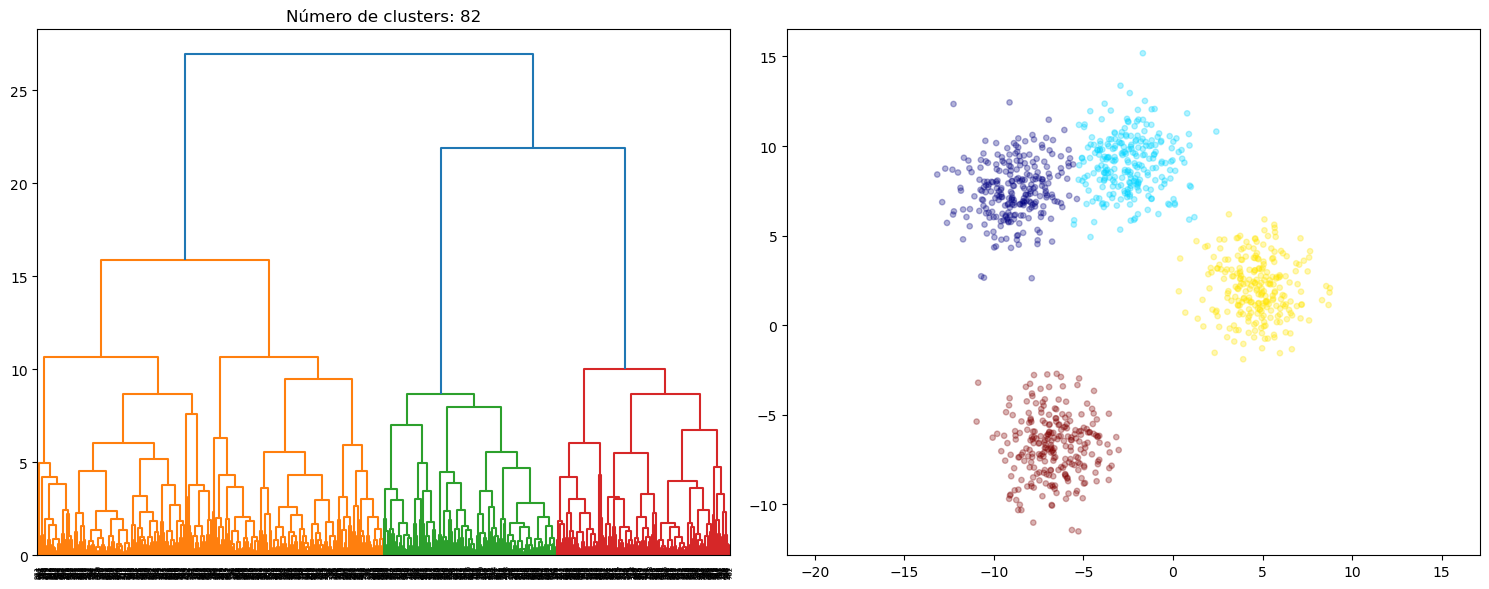

In [45]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
lin = linkage(pdist(X), method='complete')
dendrogram(lin, ax=ax[0])
ax[0].set_title(f'Número de clusters: {len(set(fcluster(lin, 2.1, criterion="distance")))}')
cluster_idx = fcluster(lin, t=15, criterion="distance")
ax[1].scatter(X[:,0], X[:,1], s=15, c=cluster_idx, alpha=.3, cmap='jet')
ax[1].axis('equal')
plt.tight_layout()


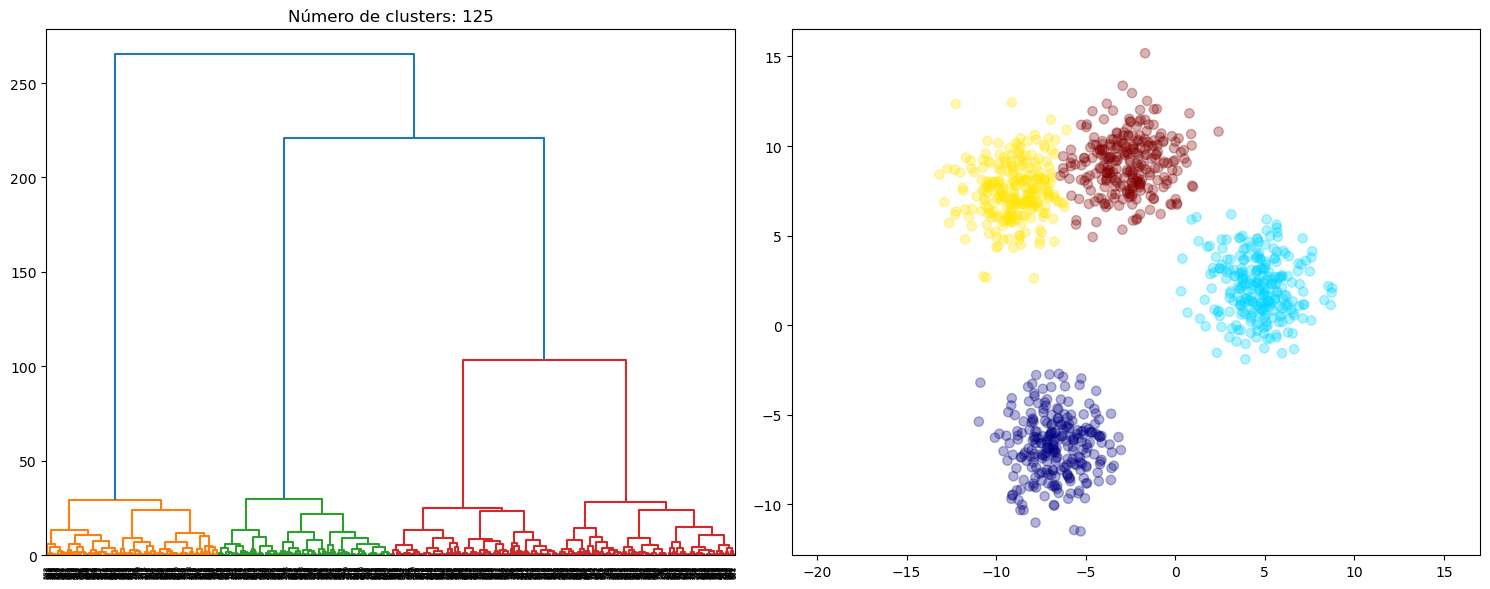

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
lin = linkage(pdist(X), method='ward')
dendrogram(lin, ax=ax[0])
ax[0].set_title(f'Número de clusters: {len(set(fcluster(lin, 2.1, criterion="distance")))}')
cluster_idx = fcluster(lin, t=45, criterion="distance")
ax[1].scatter(X[:,0], X[:,1], s=45, c=cluster_idx, alpha=.3, cmap='jet')
ax[1].axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

Los enlaces complete y ward son los que, para este dataset, permite distinguir mejor los clusters esperados.

Ya que hay dos nubes muy cerca por lo que el enlace simple las hace dificilmente distinguibles.

In [48]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

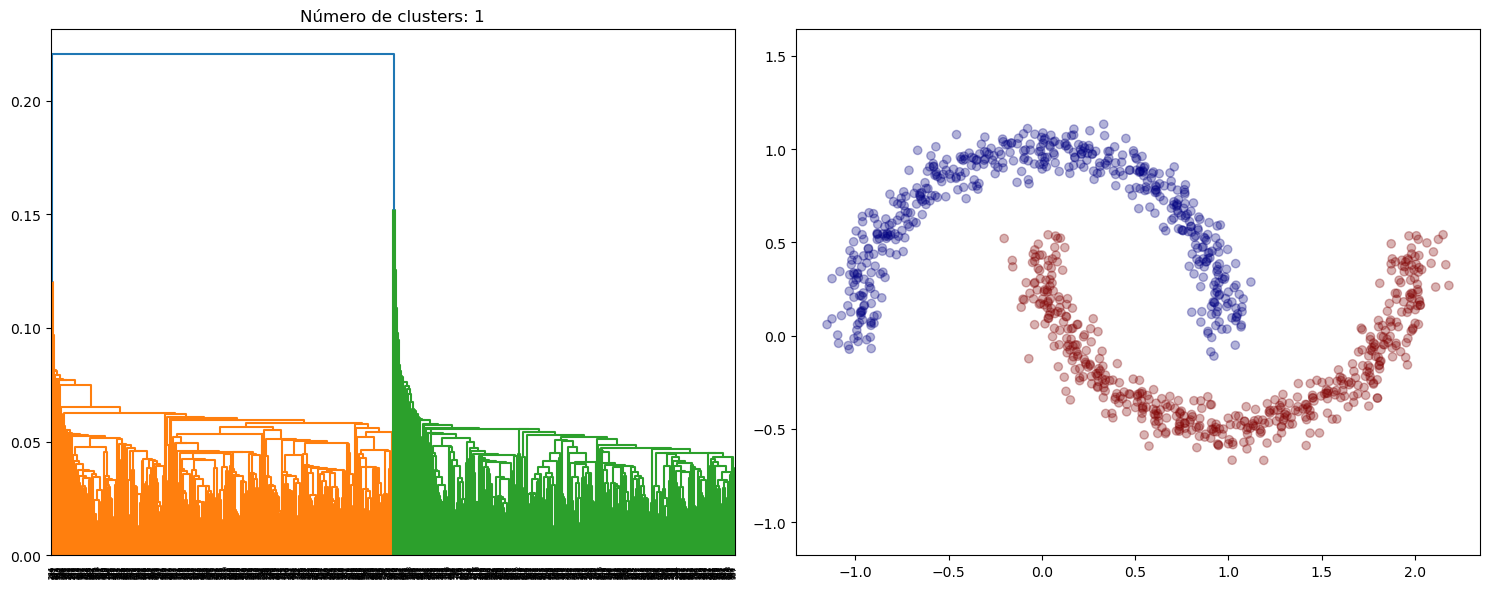

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
lin = linkage(pdist(X), method='single')
dendrogram(lin, ax=ax[0])
ax[0].set_title(f'Número de clusters: {len(set(fcluster(lin, 2.1, criterion="distance")))}')
cluster_idx = fcluster(lin, t=.20, criterion="distance")
ax[1].scatter(X[:,0], X[:,1], c=cluster_idx, alpha=.3, cmap='jet')
ax[1].axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

El enlace simple es el que, para este dataset, permite distinguir mejor los clusters esperados.

El enlace simple, definido como la mínima distancia entre elementos de cada cluster

In [24]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

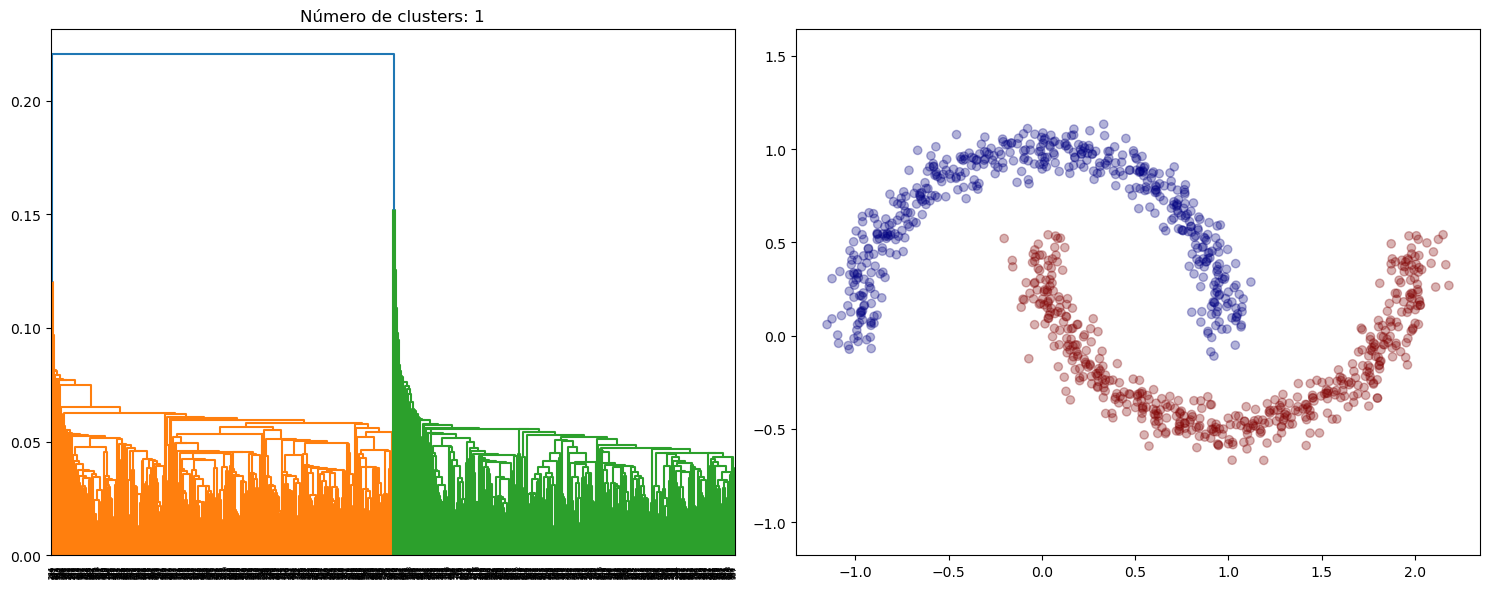

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
lin = linkage(pdist(X), method='single')
dendrogram(lin, ax=ax[0])
ax[0].set_title(f'Número de clusters: {len(set(fcluster(lin, 2.1, criterion="distance")))}')
cluster_idx = fcluster(lin, t=.20, criterion="distance")
ax[1].scatter(X[:,0], X[:,1], c=cluster_idx, alpha=.3, cmap='jet')
ax[1].axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

El enlace simple es el que, para este dataset, permite distinguir mejor los clusters esperados.

El enlace simple, definido como la mínima distancia entre elementos de cada cluster

<a id="ej2"></a>

## 2. Ejemplo práctico: diseño de redes de transporte (5 puntos)

Imaginemos que un famoso magnate llamado Melon Mask ha culminado su nuevo invento: el hypermegaminiloop. Que revoluciona el transporte urbano, pero de momento es muy muy caro.

El alcalde de Nueva York se ha enterado de su existencia y quiere ser un *early adopter* del proyecto y complementar (que no sustituir) su red de transporte. Para ello se dispone de datos de la [demanda de Uber](https://data.world/data-society/uber-pickups-in-nyc) que con este nuevo método se pretende cubrir.

Se provee de un subconjunto del dato representativo pero de menor tamaño para evitar que su procesado conlleve tiempos de ejecución muy grandes.

In [26]:
df = pd.read_csv('uber_sample.csv')
df.head(3)

,Date/Time,Lat,Lon,Base
0,9/16/2014 5:37:00,40.7651,-73.9615,B02764
1,9/21/2014 12:12:00,40.7249,-73.9947,B02764
2,9/22/2014 12:50:00,40.7720,-73.9590,B02598


Visualizamos los datos para ver donde hay mayor concentración de peticiones y facilitar el posterior análisis de los datos. ¿Puedes localizar *Central Park*?

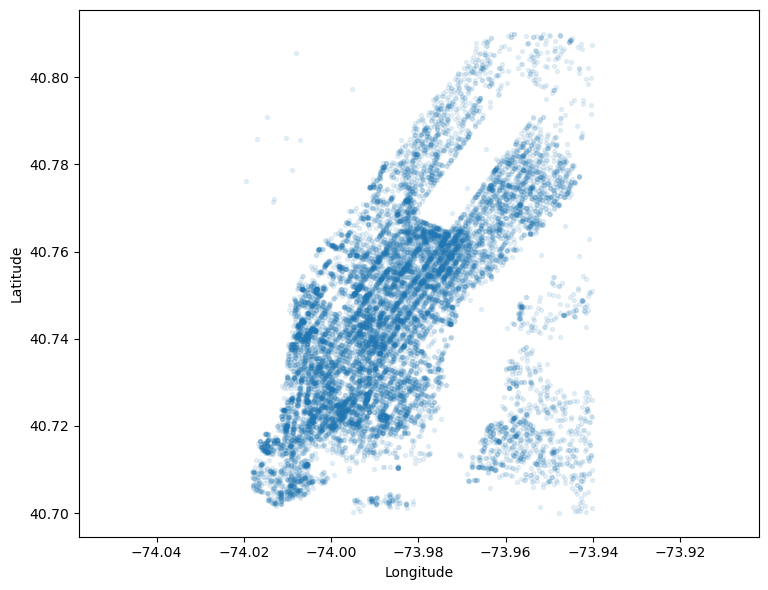

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(df['Lon'], df['Lat'], s=8, alpha=.1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')
plt.tight_layout()

### 2 a. Localización de las paradas: clustering

La primera parte del diseño de la red de transporte es situar las futuras paradas. Para ello tendrás que identificar entre 100 y 200 lugares del mapa (aproximación aportada por el departamento de transporte de la ciudad) con alta concentración de demanda.

Puedes elegir cualquier algoritmo de clustering para este cometido, pero recuerda que tendrás que justificar la respuesta para la propuesta de proyecto.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
elige y aplica una técnica de clustering para encontrar entre 100 y 200 grupos de puntos.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los grupos encontrados dotando de color a los puntos en base al cluster al que pertenecen. Puedes utilizar el colormap 'tab20' para tener una paleta de color discreta y amplia que permita visualizar mejor los resultados.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    De cara a la redacción de la propuesta de proyecto, ¿por qué has elegido este método de agrupamiento?
</div>

### 2 b. Análisis de grupos y preparación de datos

Antes de continuar con el diseño de la red de transporte hay que validar que los grupos tienen sentido.

Lo primero es estimar la densidad de cada grupo encontrado:

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
calcula para cada cluster su área:
    <br/>
    1. Puedes simplificarla de la siguiente manera: (lat_max - lat_min) * (lon_max - lon_min), cuidado con los valores negativos, de los puntos que pertenecen al grupo.
    <br/>
    2. También calcula el número de puntos que pertenecen a cada grupo.
    <br/>
    3. Calcula el siguiente ratio: número de puntos (2) por área cubierta (1) de cada cluster.
    <br/>
    Por último, visualiza para cada cluster el resultado de este cálculo (3) en un diagrama de barras.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    ¿Observas alguna situación sospechosa? Analízala y, si es necesario, limpia el dato para las siguientes fases.
</div>

### 2 c. Diseño de la red de transporte

Debido a que la tecnología es muy nueva y cara, tenemos el mandato de hacer un diseño que minimice la extensión de la red tratando de dar cobertura al mayor número de peticiones posibles.

Para ello se pueden usar distintas estrategias. Entre ellas la familia *MST* o [*Minimum Spanning Tree*](https://en.wikipedia.org/wiki/Minimum_spanning_tree), con algoritmos como el de [*Kruskal*](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm) o *Prim*. El algoritmo de *Kruskal* tiene la ventaja de ser muy rápido por ser *greedy* o voraz (subóptimo) y, además, evita ciclos. Un beneficio extra, ya que en nuestro caso establecería enlaces redundantes, los cuales queremos evitar por el elevado coste.

Los pasos son los siguientes:
1. Preparar los datos para el grafo.
2. Aplicar el algoritmo de Kruskal.
3. Analizar los resultados y decidir el diseño final de la red.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un dataframe en el que haya una fila por cluster y ésta contenga: <b>id</b> del cluster (numérico), <b>latitud</b> y <b>longitud</b> (representativa del cluster), y <b>número de puntos</b> pertenecientes al cluster.
</div>

Para crear el grafo no dirigido (si 1 está conectado con 2 se asume la dirección inversa) a partir del cual el algoritmo de *Kruskal* seleccionará los enlaces es necesario indicarle las posibles aristas del grafo.

Para crear el grafo simplemente hay que instanciar la clase `Graph` del módulo *kruskal* que hemos modificado a partir de [aquí](https://www.pythonpool.com/kruskals-algorithm-python/). Indicando en el parámetro `vertex` de su constructor el id más alto de cluster +1. Posteriormente se pueden añadir aristas al grafo indicando primero los dos ids de clusters que une el tramo y por último su peso que viene indicado por la definición de *weight* más adelante.

Por último, se calcula el resultado de *Kruskal* sobre el grafo haciendo una llamada al método `kruskal`, que también dispone de un parámetro `max_links` si sólo deseamos que se generen tantos tramos como se indiquen (útil más adelante).

Un ejemplo concreto sería el siguiente:

```
g = kruskal.Graph(vertex=5)
g.add_edge(0, 1, 8)
...
g.add_edge(3, 4, 7)
g.kruskal()
```

Debido al alto coste es necesario justificar la construcción de cada tramo del *hypermegaminiloop*, por lo que vamos a emplear una métrica que pese (*weight*) cada tramo (unión entre 2 clusters cualquiera $i$ y $j$):

$$weight(i, j) = -\frac{n_i+n_j}{dist(i, j)}$$

Donde:
 - $n_i$ es el número de puntos del cluster $i$, de la misma manera $n_j$ es el número de puntos del cluster $j$.
 - $dist(i, j)$ es la distancia geográfica en km entre el centro del cluster $i$ y el cluster $j$.
 
La distancia geográfica entre 2 puntos cualesquiera no es la distancia euclídea, puesto que la tierra tiene curvatura. Para ello puedes usar el módulo [haversine](https://pypi.org/project/haversine/) (ya importado como *hs* al inicio de la PEC).

Por último, resaltar que el peso final es negativo porque el algoritmo de *Kruskal* ve este peso como un coste que trata de minimizar. Por nuestra parte, deseamos incentivar que a medida que más alto sea el ratio descrito más atractivo le sea a *Kruskal*, por eso se hace negativo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un grafo siguiendo el código de ejemplo en el que aparezcan todos los pares de clusters posibles (no hace falta repetir los pares porque se trata de un grafo no dirigido donde A-B también equivale a B-A), donde el peso (último parámetro del método add_edge) se calcule tal y como se describe en la fórmula de weight.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
aplica el algoritmo de Kruskal llamando al método kruskal del grafo variando el número de ejes en función de tu criterio (compromiso entre extensión y coste).
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los centros de los clusters indicando su importancia (por ejemplo incrementando su diámetro o cambiar su color en función del número de puntos que contiene) y sus enlaces indicando también su importancia (mediante su grosor o transparencia) producidos por la salida de Kruskal.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    Además del método de Kruskal ¿se te ocurren o conoces otros métodos que podrían mejorar la solución? Descríbelo brevemente.
</div>

### 2 d. [OPCIONAL] Visualización sobre el mapa

Para observar cómo queda el proyecto sobre el plano se puede usar la librería [smopy](https://github.com/rossant/smopy) que se apoya en [OpenStreetMap](https://www.openstreetmap.org/).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los enlaces indicando su importancia (mediante su grosor o transparencia) producidos por la salida de Kruskal sobre el plano.
</div>